# Kaggle House Prices

## Initialization

In [113]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor
from sklearn import model_selection
from sklearn import preprocessing

In [114]:
df_train_raw = pd.read_csv("train.csv", index_col=0)

## Data Preprocessing

In [115]:
# drop useless columns
uselessColumns = set(["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "1stFlrSF", "2ndFlrSF",'Condition1', 'Condition2'])

oneHotCategoryColumns = set(["MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour",
                            "LotConfig", "LandSlope", "Neighborhood", "HouseStyle", "RoofStyle",
                            "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation",
                            "Heating", "CentralAir", "Electrical", "GarageType", "PavedDrive",
                            "SaleType", "SaleCondition", "BldgType"])

ordinalCategoryColumns = set(["OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtQual",
                            "BsmtCond", "BsmtExposure", "BsmtFinType2", "HeatingQC", "BsmtFullBath",
                            "BsmtHalfBath", "FullBath", "HalfBath", "KitchenQual", "Functional",
                            "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond", "PoolQC",
                            "Fence", "BsmtFinType1"])

specificOneHotColumns = set(["Utilities", "Condition1", "Condition2", "MiscFeature"])

numericColumns = set(["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2",
                    "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF",
                    "GrLivArea", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces",
                    "GarageYrBlt", "GarageCars", "GarageArea", "WoodDeckSF", "OpenPorchSF",
                    "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal",
                    'DateSold'])

dateTimeColumns = set(["YearBuilt", "YearRemodAdd"])

def preprocessData(df, verbose=False, dropUseless=True):
    # modify date column
    df.loc[:, 'DateSold'] = df['YrSold'] + df['MoSold'] / 12.0
    df.drop(['YrSold', 'MoSold'], inplace=True, axis=1)

    # convert one-hot columns
    for col in df.columns:
        if verbose : print(col.ljust(15), str(df[col].dtype).ljust(10), end="")
        if col == "SalePrice":
            if verbose : print(": Target feature, Don't change it!!!")
        # create category
        elif col in ordinalCategoryColumns:
            if verbose : print(": Categorical, convert to category codes")
            df.loc[:, col] = df[col].fillna('None')
            df.loc[:, col] = df[col].astype('category')
            df[col + "Code"] = df[col].cat.codes
            df.drop(col, axis=1, inplace=True)

        # one hot encoding
        elif col in oneHotCategoryColumns:
            if verbose : print(": One-Hot, generate one-hot encoding")
            df = pd.concat([df,pd.get_dummies(df[col], prefix=col, prefix_sep="=")],axis=1)
            df.drop(col, axis=1, inplace=True)

        # numeric values, nothing to do
        elif col in numericColumns:
            if verbose : print(": Numeric, add missing values, nothing more to do")
            df.loc[:, col] = (df[col] - df[col].mean()) / df[col].std()
            df.loc[:, col] = df[col].interpolate(method='akima')

        # specific columns
        elif col == "MiscFeature":
            if verbose : print(": Misc Feature, one-hot encoding")
            df[col].fillna("None", inplace=True)
            df = pd.concat([df,pd.get_dummies(df[col], prefix=col, prefix_sep="=")],axis=1)
            df.drop(col, axis=1, inplace=True)

        # specific colum, only 2 values so kept as a boolean column
        elif col == "Utilities":  #'AllPub', 'NoSeWa' just boolean
            if verbose : print(": Utilities, only 2 values, convert to boolean")
            df[col].fillna("None")
            df = pd.concat([df,pd.get_dummies(df[col], prefix=col, prefix_sep="=")],axis=1)
            df.drop(col, axis=1, inplace=True)

        elif col in dateTimeColumns:
            if verbose : print(": Datetime, keep as float for regression")
        else:
            if verbose : print(": UNKNOWN")

    # drop useless columns
    if dropUseless : df.drop(uselessColumns, axis=1, inplace=True)
    return df

## Data Vizualization

In [116]:
df_train = df_train_raw.copy()
df_train = preprocessData(df_train)
df_train.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,...,SaleType=ConLw,SaleType=New,SaleType=Oth,SaleType=WD,SaleCondition=Abnorml,SaleCondition=AdjLand,SaleCondition=Alloca,SaleCondition=Family,SaleCondition=Normal,SaleCondition=Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,-0.207948,-0.207071,2003,2003,0.509840,-0.459145,-0.120201,0.370207,0.163723,-0.211381,...,0,0,0,1,0,0,0,0,1,0
2,0.409724,-0.091855,1976,1976,-0.572637,0.466305,-0.120201,-0.482347,0.163723,-0.211381,...,0,0,0,1,0,0,0,0,1,0
3,-0.084413,0.073455,2001,2002,0.322063,-0.313261,-0.120201,0.514836,0.163723,-0.211381,...,0,0,0,1,0,0,0,0,1,0
4,-0.413838,-0.096864,1915,1970,-0.572637,-0.687089,-0.120201,0.383528,0.163723,-0.211381,...,0,0,0,1,1,0,0,0,0,0
5,0.574436,0.375020,2000,2000,1.360357,0.199611,-0.120201,1.298881,1.389547,-0.211381,...,0,0,0,1,0,0,0,0,1,0


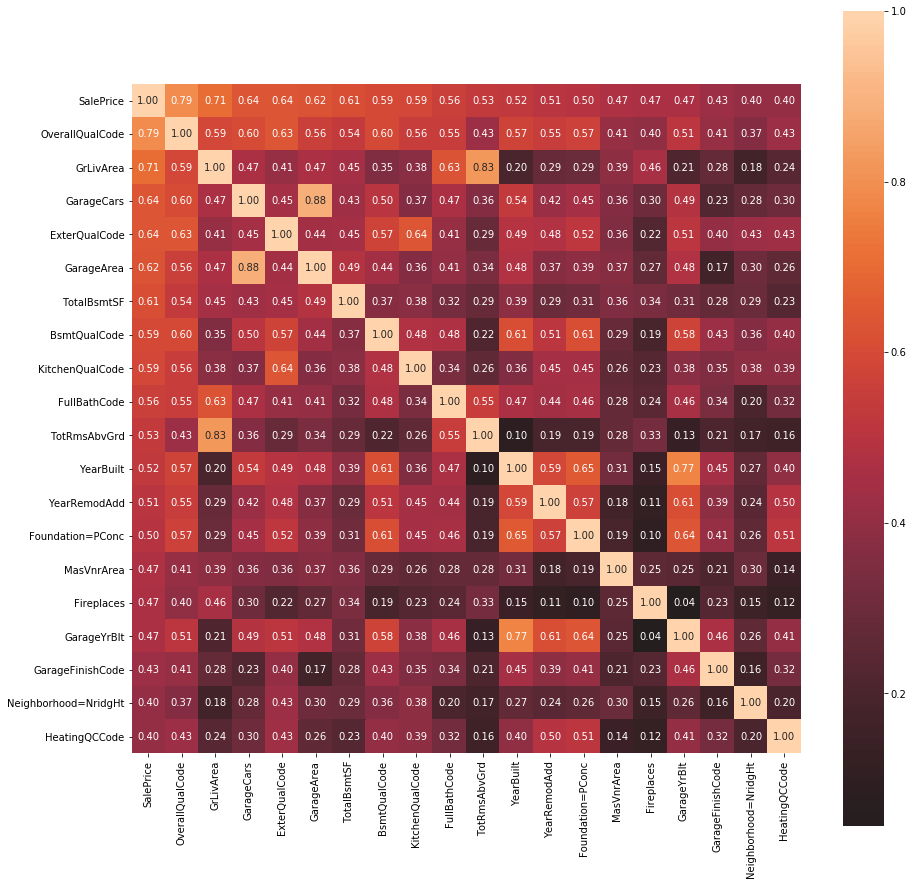

In [117]:
corrmat = df_train.corr().abs()
cols = corrmat.nlargest(20, 'SalePrice')['SalePrice'].index
corrmat = corrmat.nlargest(20, 'SalePrice')[cols]
plt.figure(figsize=(15, 15))
sb.heatmap(corrmat,annot=True,square=True,center=0,fmt='.2f',yticklabels=cols.values,xticklabels=cols.values)
plt.show()

In [118]:
nbFeatures = 10
className = 'SalePrice'

In [119]:
Y = df_train[className]
X = df_train.drop(className, axis=1)

# Build a forest and compute the feature importances
forest = ExtraTreesRegressor(n_estimators=250, random_state=0)
forest.fit(X, Y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking (10 most important):")

for f in range(10):
    print("%d. feature %d (%s) (%f)" %
          (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))

Feature ranking (10 most important):
1. feature 103 (OverallQualCode) (0.260303)
2. feature 13 (GarageCars) (0.113015)
3. feature 154 (ExterQualCode) (0.100497)
4. feature 7 (GrLivArea) (0.078518)
5. feature 185 (KitchenQualCode) (0.052046)
6. feature 162 (BsmtQualCode) (0.051785)
7. feature 183 (FullBathCode) (0.032562)
8. feature 2 (YearBuilt) (0.025995)
9. feature 5 (TotalBsmtSF) (0.021673)
10. feature 80 (Neighborhood=NoRidge) (0.018777)


In [120]:
featuresNames = list(X.columns[indices[:nbFeatures]])
featuresNames

['OverallQualCode',
 'GarageCars',
 'ExterQualCode',
 'GrLivArea',
 'KitchenQualCode',
 'BsmtQualCode',
 'FullBathCode',
 'YearBuilt',
 'TotalBsmtSF',
 'Neighborhood=NoRidge']

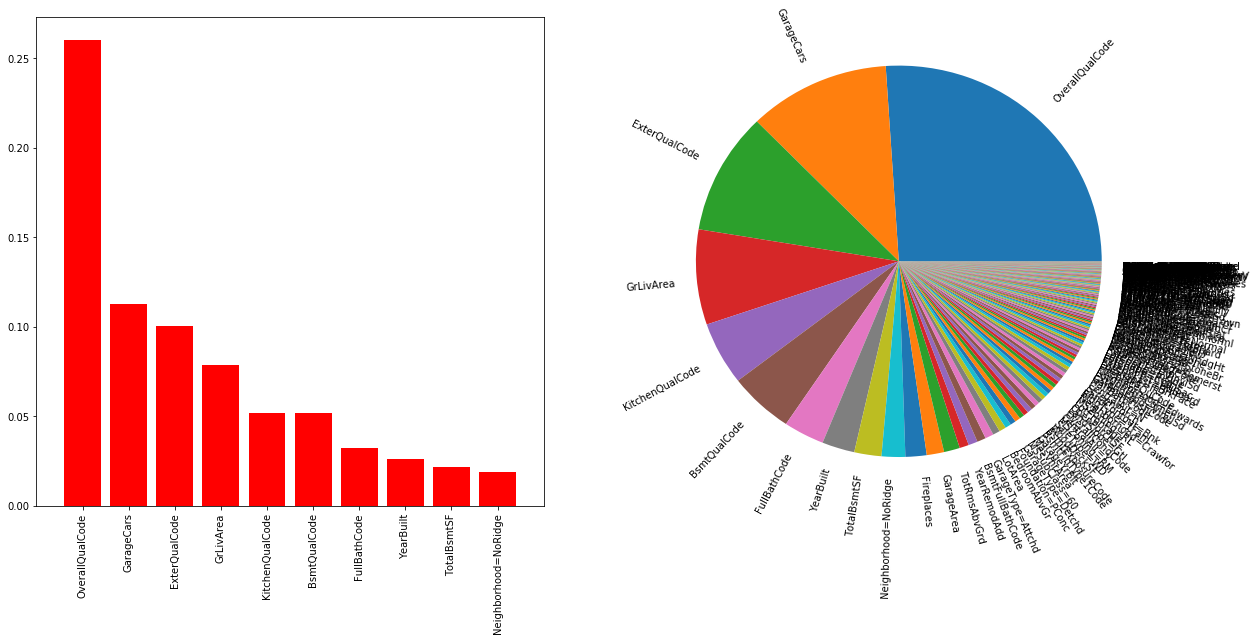

In [121]:
# Plot the feature importances of the forest
plt.figure(figsize=(20, 9))
plt.title("Feature importances")

plt.subplot(1, 2, 1)
plt.bar(range(nbFeatures),importances[indices[:nbFeatures]],color="r",align="center")
plt.xticks(range(nbFeatures), X.columns[indices[:nbFeatures]], rotation=90)
plt.xlim([-1, nbFeatures])

plt.subplot(1, 2, 2)
plt.pie(importances[indices], labels=X.columns[indices], rotatelabels=True)
plt.show()

## Model training

In [122]:
# numericfeatures only
numericFeatures = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2",
                    "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF",
                    "GrLivArea", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces",
                    "GarageYrBlt", "GarageCars", "GarageArea", "WoodDeckSF", "OpenPorchSF",
                    "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal",
                    'DateSold']
df_train = df_train_raw.copy()
df_train = preprocessData(df_train, dropUseless=False, verbose=False)
df_train.head()

,LotFrontage,LotArea,Condition1,Condition2,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType=ConLw,SaleType=New,SaleType=Oth,SaleType=WD,SaleCondition=Abnorml,SaleCondition=AdjLand,SaleCondition=Alloca,SaleCondition=Family,SaleCondition=Normal,SaleCondition=Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,-0.207948,-0.207071,Norm,Norm,2003,2003,0.509840,0.575228,-0.288554,-0.944267,...,0,0,0,1,0,0,0,0,1,0
2,0.409724,-0.091855,Feedr,Norm,1976,1976,-0.572637,1.171591,-0.288554,-0.641008,...,0,0,0,1,0,0,0,0,1,0
3,-0.084413,0.073455,Norm,Norm,2001,2002,0.322063,0.092875,-0.288554,-0.301540,...,0,0,0,1,0,0,0,0,1,0
4,-0.413838,-0.096864,Norm,Norm,1915,1970,-0.572637,-0.499103,-0.288554,-0.061648,...,0,0,0,1,1,0,0,0,0,0
5,0.574436,0.375020,Norm,Norm,2000,2000,1.360357,0.463410,-0.288554,-0.174805,...,0,0,0,1,0,0,0,0,1,0


In [123]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn import model_selection as ms
from sklearn.metrics import accuracy_score

models = [LinearRegression(),
          Lasso(alpha=1.0),
          Ridge(alpha=1.0),
          SGDRegressor(max_iter=5, tol=None),
          GaussianNB(),
          DecisionTreeRegressor(),
          GradientBoostingRegressor(),
          RandomForestRegressor()]

# preparing X and Y before split
X_all = df_train[numericFeatures]
y_all = df_train[className]
X_train, X_test, Y_train, Y_test = ms.train_test_split(X_all, y_all, test_size=0.20)

modelScores = {}
for i, mod in enumerate(models):
    print(mod.__class__.__name__.ljust(25), end="")
    mod.fit(X_train, Y_train)
    predictions = mod.predict(X_test)
    accuracy = mod.score(X_test, Y_test)
    print("Accuracy : ", accuracy)
    modelScores[mod] = accuracy

bestModel = max(modelScores, key=lambda k: modelScores[k])
bestAccuracy = max(modelScores.values())
print("Best model:", bestModel, bestAccuracy)

LinearRegression         Accuracy :  0.5093053705613668
Lasso                    Accuracy :  0.5093267358277541
Ridge                    Accuracy :  0.5094919451280239
SGDRegressor             Accuracy :  0.4939498210973351
GaussianNB               

C:\Users\Amaury\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Accuracy :  0.010273972602739725
DecisionTreeRegressor    Accuracy :  0.6671557789259868
GradientBoostingRegressorAccuracy :  0.8696307650485272
RandomForestRegressor    Accuracy :  0.8037508286871987
Best model: GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False) 0.8696307650485272


## Submission

In [124]:
## prepare the df_test dataframe
df_test = pd.read_csv('test.csv', index_col=0)
df_test = preprocessData(df_test, dropUseless=False)
df_test.head()

,LotFrontage,LotArea,Condition1,Condition2,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType=ConLw,SaleType=New,SaleType=Oth,SaleType=WD,SaleCondition=Abnorml,SaleCondition=AdjLand,SaleCondition=Alloca,SaleCondition=Family,SaleCondition=Normal,SaleCondition=Partial
Id,,,,,,,,,,,,,,,,,,,,,
1461,0.510333,0.363804,Feedr,Norm,1961,1961,-0.566973,0.063251,0.516994,-0.650173,...,0,0,0,1,0,0,0,0,1,0
1462,0.555022,0.897553,Norm,Norm,1958,1958,0.041046,1.062663,-0.297698,-0.339145,...,0,0,0,1,0,0,0,0,1,0
1463,0.242199,0.809368,Norm,Norm,1997,1998,-0.566973,0.772723,-0.297698,-0.954339,...,0,0,0,1,0,0,0,0,1,0
1464,0.420955,0.032053,Norm,Norm,1998,1998,-0.454377,0.357583,-0.297698,-0.526677,...,0,0,0,1,0,0,0,0,1,0
1465,-1.143162,-0.971475,Norm,Norm,1992,1992,-0.566973,-0.387033,-0.297698,1.058191,...,0,0,0,1,0,0,0,0,1,0


In [125]:
y_pred = bestModel.predict(df_test[numericFeatures])
df_submission = pd.DataFrame(index=df_test.index)
df_submission['SalePrice'] = y_pred
df_submission.to_csv('submission.csv', header=True)
df_submission.head()

,SalePrice
Id,
1461,118865.055950
1462,145263.957360
1463,205545.584046
1464,187377.202209
1465,164000.317519


In [126]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "Message"

Successfully submitted to House Prices: Advanced Regression Techniques


In [127]:
!kg submit -c house-prices-advanced-regression-techniques submission.csv -m "Fixed?"

'NoneType' object has no attribute 'group'
